<h1>Objective :</h1>
<h3>The goal is to predict whether food delivery will be fast or delayed based on features like customer location, restaurant location, weather conditions, traffic conditions, and more. This task is a binary classification problem where the model will predict delivery status: "Fast" or "Delayed."</h3>

<h1>Phase 1<br>Data Preprocessing</h1>(2 steps)

<h3>Step 1 - Data Import and Cleaning</h3>

In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [397]:
data=pd.read_csv('Food_Delivery_Time_prediction.csv')
d=data.copy()
d.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [398]:
d.isnull().sum()

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

Null values do not exist in any column<br>
Now checking for incorrect data

In [399]:
#drop duplicate and empty rows of Order_ID column
d.dropna(subset=['Order_ID'])
d.drop_duplicates(subset='Order_ID', keep='first')
# drop incorrect data for Order_ID column
d.drop(d[ d['Order_ID'].str.match(r'^ORD\d{4}$')==False ].index, inplace=True) 
# here if inplace=True not used then the changes will not be applied to the original dataframe 

#drop rows with null values in Customer_Location column
d.dropna(subset=['Customer_Location'], inplace=True)

#drop rows with null values in Restaurant_Location column
d.dropna(subset=['Restaurant_Location'], inplace=True)

# # distance values all greater than 0
# d.loc[d['Distance']<=0,'Distance']=np.mean(d[d['Distance']>0]['Distance'])

# fill null values in Weather_Conditions with 'Sunny'
# Weather_Conditions values should be one of the following
d['Weather_Conditions'].fillna('Sunny')
valid_weather_conditions = ['Sunny', 'Rainy', 'Snowy', 'Cloudy']
d.loc[~d['Weather_Conditions'].isin(valid_weather_conditions), 'Weather_Conditions'] = 'Sunny'

# fill null values in Traffic_Conditions with 'Medium'
# Traffic_Conditions values should be one of the following
d['Traffic_Conditions'].fillna('Medium')
valid_traffic_conditions = ['Low', 'Medium', 'High']
d.loc[~d['Traffic_Conditions'].isin(valid_traffic_conditions), 'Traffic_Condisions'] = 'Medium'

# # Deliver_Person_Experience values should be positive and non-zero
# d.loc[d['Delivery_Person_Experience']<=0,'Delivery_Person_Experience']=np.mean(d.loc[d['Delivery_Person_Experience']>0,'Delivery_Person_Experience'])

# fill null values in Order_Priority with 'Medium'
# Order_Priority values should be one of the following
d['Order_Priority'].fillna('Medium')
valid_order_priority = ['Low', 'Medium', 'High']
d.loc[~d['Order_Priority'].isin(valid_order_priority), 'Order_Priority'] = 'Medium'

# fill null values in Order_Time with 'Night'
# Order_Time values should be one of the following
d['Order_Time'].fillna('Night')
valid_order_time = ['Afternoon', 'Night', 'Evening', 'Morning']
d.loc[~d['Order_Time'].isin(valid_order_time), 'Order_Time'] = 'Night'

# fill null values in Vehicle_Type with 'Bike'
# Vehicle_Type values should be one of the following
d['Vehicle_Type'].fillna('Bike')
valid_vehicle_type = ['Car', 'Bike', 'Bicycle']
d.loc[~d['Vehicle_Type'].isin(valid_vehicle_type), 'Vehicle_Type'] = 'Bike'


In [400]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,Cloudy,High,8,Medium,Night,Bike,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,Snowy,Medium,8,Low,Night,Bicycle,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,Snowy,High,4,Medium,Afternoon,Bike,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,Rainy,High,9,Low,Night,Car,3.9,4.8,53.94,354.39,85.25,NaN


In [401]:
# Setting numeric values to column Weather_Conditions
weather_map = {'Sunny': 0, 'Rainy': 1, 'Snowy': 2, 'Cloudy': 3}
d['Weather_Conditions'] = d['Weather_Conditions'].map(weather_map)

# Setting numeric values to column Traffic_Conditions
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
d['Traffic_Conditions'] = d['Traffic_Conditions'].map(traffic_map)

# Setting numeric values to column Vehicle_Type
vehicle_type_map = {'Bicycle': 0, 'Bike': 1, 'Car': 2}
d['Vehicle_Type'] = d['Vehicle_Type'].map(vehicle_type_map)

In [402]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN


In [403]:
# Standardization
s=StandardScaler()
d['Distance_Scaled'] = s.fit_transform(d[['Distance']])
d['Delivery_Time_Scaled'] = s.fit_transform(d[['Delivery_Time']])
# StandardScaler().fit_transform() expects a 2D array or DataFrame, but you passed a Series (d['Distance']), which is 1D.
# So pass a DataFrame with double brackets d[['Distance']]

In [404]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356


<h3>Step 2 - Feature Engineering</h3>

In [405]:
def haversine_formula(coords_array1, coords_array2):
    lat1 = coords_array1[:,0]
    lon1 = coords_array1[:,1]
    lat2 = coords_array2[:,0]
    lon2 = coords_array2[:,1]
    # Convert decimal degrees to radians 
    lat1=np.radians(lat1)
    lon1=np.radians(lon1)
    lat2=np.radians(lat2)
    lon2=np.radians(lon2)
    # Haversine formula 
    lat_diff = lat2 - lat1 
    lon_diff = lon2 - lon1 
    a = np.sin(lat_diff/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff/2)**2
    c = 2 * np.asin(np.sqrt(a)) 
    r = 6371  # Radius of earth in km
    return c * r

def parse_location(loc_str):
    # Remove parentheses and split by comma
    lat, lon = loc_str.strip("()").split(",")
    return float(lat), float(lon)

coords_array1 = d['Customer_Location'].apply(parse_location).tolist()
coords_array1 = np.array(coords_array1)

coords_array2 = d['Restaurant_Location'].apply(parse_location).tolist()
coords_array2 = np.array(coords_array2)

d['Calculated_Distance'] = haversine_formula(coords_array1, coords_array2)

In [406]:
d[['Calculated_Distance']]

,Calculated_Distance
0,775.651198
1,1042.385597
2,476.220706
3,389.912629
4,806.505886
...,...
195,670.130652
196,558.891202
197,106.686689
198,880.580093


In [407]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093


In [408]:
delivery_time_mean = np.mean(d['Delivery_Time'])
print(delivery_time_mean)

70.49494999999999


In [409]:
d['Delivery_Time_Binary'] = np.where(d['Delivery_Time'] > delivery_time_mean, 1, 0)
# 1 for delivery time greater than mean (Delayed), 0 for less than or equal to mean(Fast)

In [410]:
d

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Traffic_Condisions,Distance_Scaled,Delivery_Time_Scaled,Calculated_Distance,Delivery_Time_Binary
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,1,4,Medium,Afternoon,2,4.1,3.0,26.22,1321.10,81.54,NaN,-1.454738,-1.487932,775.651198,0
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,3,1,8,Low,Night,2,4.5,4.2,62.61,152.21,29.02,NaN,1.439192,-0.264987,1042.385597,0
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,1,9,High,Night,1,3.3,3.4,48.43,1644.38,64.17,NaN,-0.666417,-0.741529,476.220706,0
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,3,0,2,Medium,Evening,1,3.2,3.7,111.63,541.25,79.23,NaN,0.335835,1.382411,389.912629,1
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,2,6,Low,Night,1,3.5,2.8,32.38,619.81,2.34,NaN,-0.700119,-1.280915,806.505886,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",23.82,3,2,8,Medium,Night,1,4.7,4.0,50.39,1432.26,66.34,NaN,1.805512,-0.675660,670.130652,0
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",6.09,2,1,8,Low,Night,0,3.0,3.6,90.54,1720.25,40.27,NaN,-0.792431,0.673647,558.891202,1
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",20.61,2,2,4,Medium,Afternoon,1,2.9,3.4,73.20,1356.58,5.10,NaN,1.335157,0.090908,106.686689,1
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",24.06,1,2,9,Low,Night,2,3.9,4.8,53.94,354.39,85.25,NaN,1.840679,-0.556356,880.580093,0


<h1>Phase 2<br>Classification using Naive Bayes, K-Nearest Neighbors, and Decision Tree</h1>contains 3 steps

<h3>Step 3 - Naive Bayes Classifier</h3>

In [411]:
x=d[['Distance_Scaled', 'Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type', 'Delivery_Person_Experience']]
y=d['Delivery_Time_Binary']

In [412]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [413]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

,priors,None
,var_smoothing,1e-09


In [414]:
y_pred_gnb = gnb.predict(x_test)
y_pred_gnb

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1])

In [415]:
label_map = {0: 'Fast', 1: 'Delayed'}
y_test_labels = [label_map[label] for label in y_test]

In [416]:
label_map = {0: 'Fast', 1: 'Delayed'}
y_pred_labels_gnb = [label_map[label] for label in y_pred_gnb]

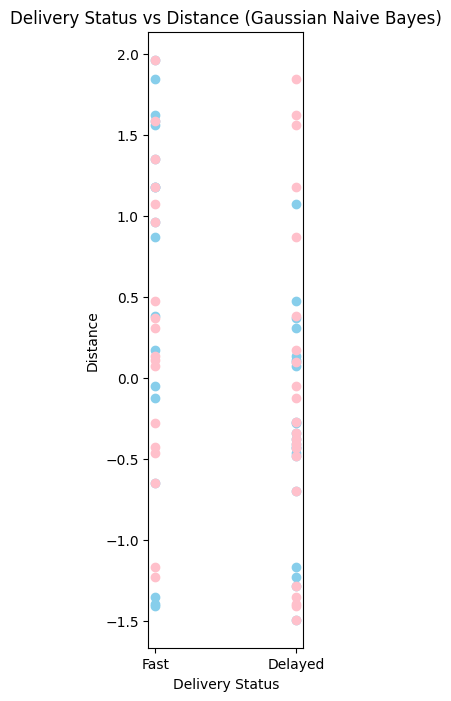

In [417]:
plt.figure(figsize=(2,8))
plt.scatter(y_pred_labels_gnb, x_test['Distance_Scaled'], color='skyblue', label='Predicted Status')
plt.scatter(y_test_labels, x_test['Distance_Scaled'], color='pink', label='Actual Status')
plt.xlabel('Delivery Status')
plt.ylabel('Distance')
plt.title('Delivery Status vs Distance (Gaussian Naive Bayes)')
plt.legend
plt.show()

<h3>Step 4 - K-Nearest Neighbors (KNN)</h3>


Optimal number of neighbors (K): 34



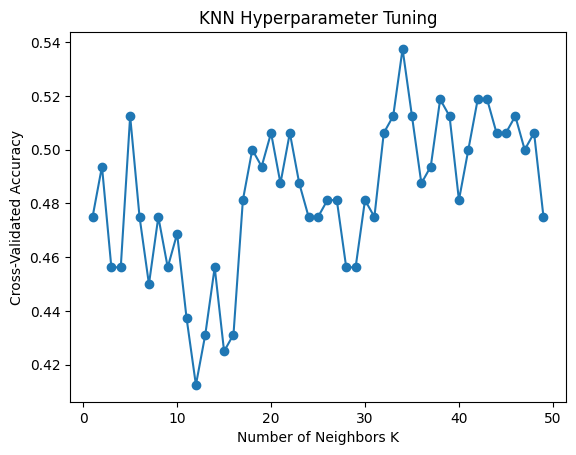

In [418]:
k_range = range(1, 50)
cv_scores = []

for k in k_range:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_cv, x_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = k_range[cv_scores.index(max(cv_scores))]
print("")
print(f"Optimal number of neighbors (K): {optimal_k}")
print("")

plt.plot(k_range, cv_scores, marker='o')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Hyperparameter Tuning')
plt.show()

In [419]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_train, y_train)

,n_neighbors,34
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [420]:
y_pred_knn = knn.predict(x_test)
y_pred_knn

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [421]:
label_map = {0: 'Fast', 1: 'Delayed'}
y_pred_labels_knn = [label_map[label] for label in y_pred_knn]

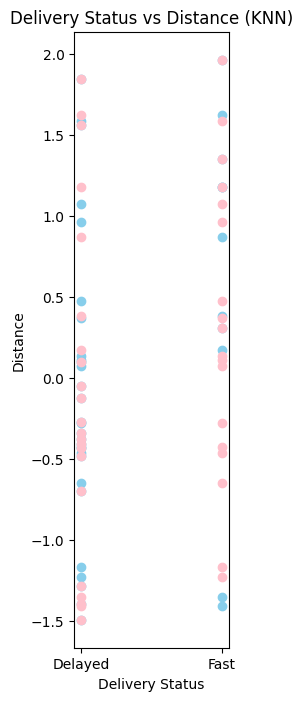

In [422]:
plt.figure(figsize=(2,8))
plt.scatter(y_pred_labels_knn, x_test['Distance_Scaled'], color='skyblue', label='Predicted Status')
plt.scatter(y_test_labels, x_test['Distance_Scaled'], color='pink', label='Actual Status')
plt.xlabel('Delivery Status')
plt.ylabel('Distance')
plt.title('Delivery Status vs Distance (KNN)')
plt.legend
plt.show()

<h3>Step 5 - Decision Tree</h3>

In [445]:
# Define parameter grid for pruning
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10, 20]
}

In [446]:
dt_grid = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_grid, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_split': 20}
Best cross-validated accuracy: 0.51875


In [447]:
# Fit and evaluate pruned tree
dt_pruned = DecisionTreeClassifier(random_state=42, **grid_search.best_params_)
dt_pruned.fit(x_train, y_train)

y_pred_dt = dt_pruned.predict(x_test)

In [448]:
label_map = {0: 'Fast', 1: 'Delayed'}
y_pred_labels_dt = [label_map[label] for label in y_pred_dt]

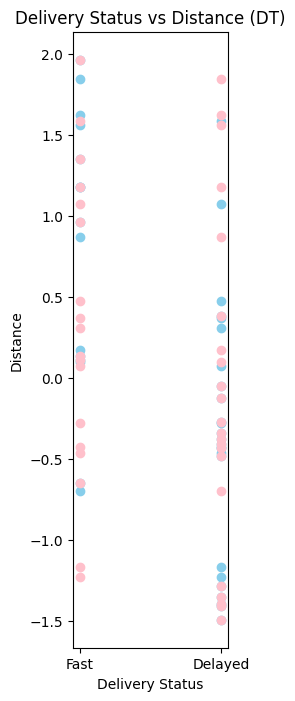

In [449]:
plt.figure(figsize=(2,8))
plt.scatter(y_pred_labels_dt, x_test['Distance_Scaled'], color='skyblue', label='Predicted Status')
plt.scatter(y_test_labels, x_test['Distance_Scaled'], color='pink', label='Actual Status')
plt.xlabel('Delivery Status')
plt.ylabel('Distance')
plt.title('Delivery Status vs Distance (DT)')
plt.legend
plt.show()

<h1>Phase 3<br>Reporting and Insights</h1>
(2 steps)

<h3>Step 6 - Model Comparison</h3>

Accuracy gnb :  0.4
Precision gnb :  0.45454545454545453
Recall gnb :  0.45454545454545453
F1 Score gnb :  0.45454545454545453

Accuracy knn :  0.475
Precision knn :  0.5172413793103449
Recall knn :  0.6818181818181818
F1 Score knn :  0.5882352941176471

Accuracy dt :  0.525
Precision dt :  0.56
Recall dt :  0.6363636363636364
F1 Score dt :  0.5957446808510638


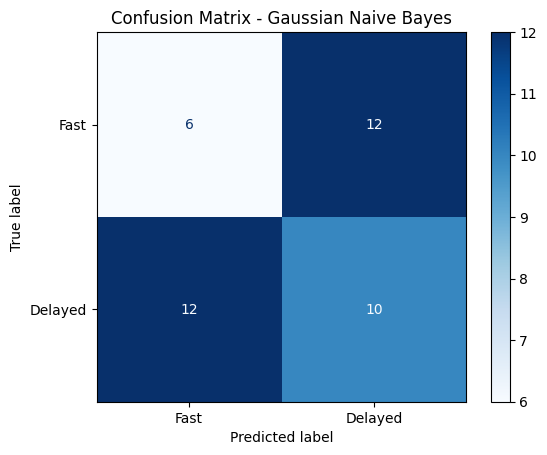

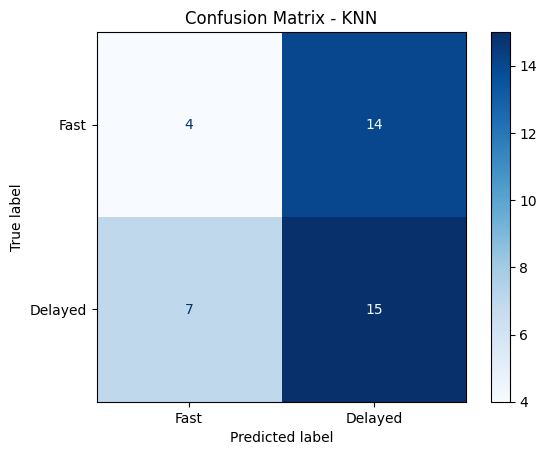

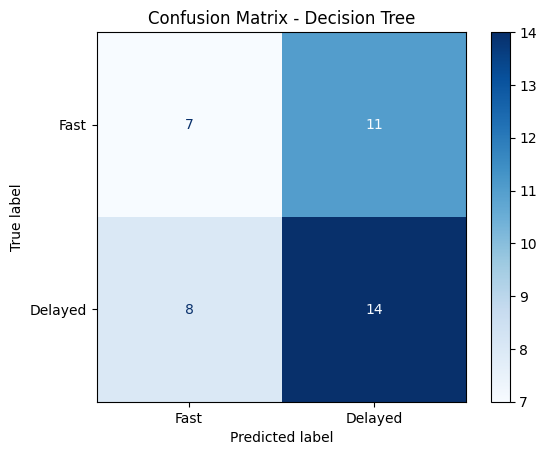

In [450]:
# Naive Bayes
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print("Accuracy gnb : ", accuracy_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb)
print("Precision gnb : ", precision_gnb)
recall_gnb = recall_score(y_test, y_pred_gnb)
print("Recall gnb : ", recall_gnb)
f1_score_gnb = f1_score(y_test, y_pred_gnb)
print("F1 Score gnb : ", f1_score_gnb)

# KNN
print("")
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy knn : ", accuracy_knn)
precision_knn = precision_score(y_test, y_pred_knn)
print("Precision knn : ", precision_knn)
recall_knn = recall_score(y_test, y_pred_knn)
print("Recall knn : ", recall_knn)
f1_score_knn = f1_score(y_test, y_pred_knn)
print("F1 Score knn : ", f1_score_knn)

# Decision Tree
print("")
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy dt : ", accuracy_dt)
precision_dt = precision_score(y_test, y_pred_dt)
print("Precision dt : ", precision_dt)
recall_dt = recall_score(y_test, y_pred_dt)
print("Recall dt : ", recall_dt)
f1_score_dt = f1_score(y_test, y_pred_dt)
print("F1 Score dt : ", f1_score_dt)

cm_gnb = confusion_matrix(y_test, y_pred_gnb)
disp_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=['Fast', 'Delayed'])
disp_gnb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Fast', 'Delayed'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - KNN')
plt.show()

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Fast', 'Delayed'])
disp_dt.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree')
plt.show()


In [451]:
cr_gnb = classification_report(y_test, y_pred_gnb, target_names=['Delayed', 'Fast'])
cr_knn = classification_report(y_test, y_pred_knn, target_names=['Delayed', 'Fast'])
cr_dt = classification_report(y_test, y_pred_dt, target_names=['Delayed', 'Fast'])

print("Gaussian Naive Bayes Classification Report:\n", cr_gnb)
print("")
print("")
print("KNN Classification Report:\n", cr_knn)
print("")
print("")
print("Decision Tree Classification Report:\n", cr_dt)

Gaussian Naive Bayes Classification Report:
               precision    recall  f1-score   support

     Delayed       0.33      0.33      0.33        18
        Fast       0.45      0.45      0.45        22

    accuracy                           0.40        40
   macro avg       0.39      0.39      0.39        40
weighted avg       0.40      0.40      0.40        40



KNN Classification Report:
               precision    recall  f1-score   support

     Delayed       0.36      0.22      0.28        18
        Fast       0.52      0.68      0.59        22

    accuracy                           0.47        40
   macro avg       0.44      0.45      0.43        40
weighted avg       0.45      0.47      0.45        40



Decision Tree Classification Report:
               precision    recall  f1-score   support

     Delayed       0.47      0.39      0.42        18
        Fast       0.56      0.64      0.60        22

    accuracy                           0.53        40
   macro avg 

ROC wants a 1D array

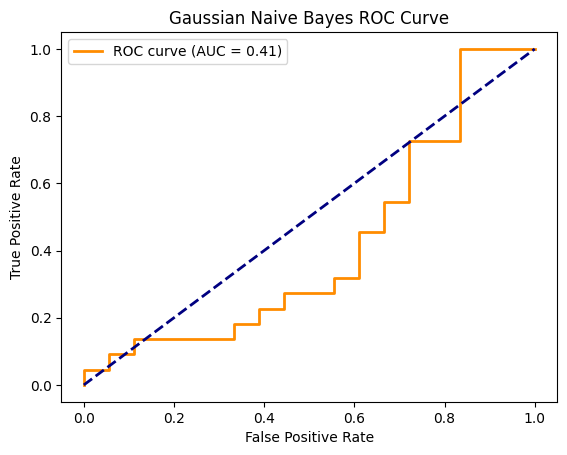

In [452]:
lb = label_binarize(y_test, classes=[0, 1])

y_test_bin = y_test.values
y_pred_prob = gnb.predict_proba(x_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes ROC Curve')
plt.legend()
plt.show()

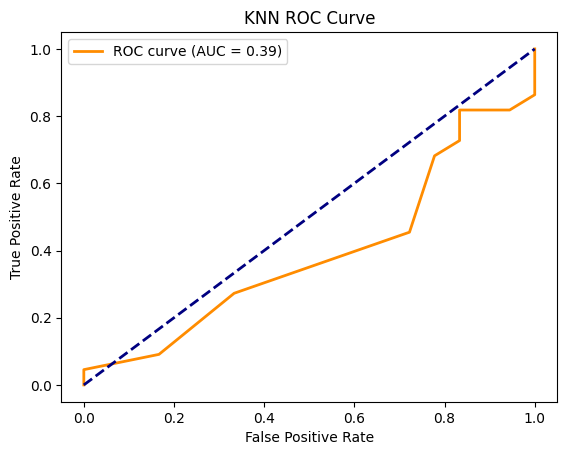

In [453]:
lb = label_binarize(y_test, classes=[0, 1])
y_test_bin = y_test.values
y_pred_prob = knn.predict_proba(x_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend()
plt.show()

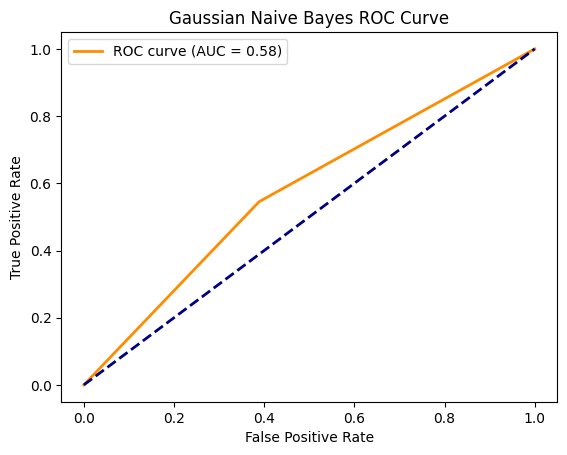

In [454]:
lb = label_binarize(y_test, classes=[0, 1])

y_test_bin = y_test.values
y_pred_prob = dt.predict_proba(x_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes ROC Curve')
plt.legend()
plt.show()

<h3>Step 7 - Actionable Insights</h3>

In [456]:
insights = """
Strengths and Weaknesses:

- Gaussian Naive Bayes (GNB):
    Strengths: Simple, fast, and works well with small datasets. Easy to implement and interpret.
    Weaknesses: Assumes feature independence and Gaussian distribution, which may not hold for this dataset. Lower accuracy (0.40) and F1 score (0.45) indicate underperformance.

- K-Nearest Neighbors (KNN):
    Strengths: Non-parametric, can capture complex relationships, and performs reasonably well (accuracy: 0.48, F1: 0.59). No strong assumptions about data distribution.
    Weaknesses: Sensitive to feature scaling, less interpretable, and computationally expensive for large datasets.

- Decision Tree (DT):
    Strengths: Highest accuracy (0.53) and F1 score (0.60). Provides clear interpretability and can handle feature interactions. Pruning helps prevent overfitting.
    Weaknesses: Can overfit if not pruned, and performance may vary with small changes in data.

Recommendation:

Based on the results, the Decision Tree classifier is recommended for this task. It offers the best balance between predictive performance and interpretability, making it suitable for understanding the factors influencing delivery delays and for deployment in real-world scenarios.
"""

print(insights)



Strengths and Weaknesses:

- Gaussian Naive Bayes (GNB):
    Strengths: Simple, fast, and works well with small datasets. Easy to implement and interpret.
    Weaknesses: Assumes feature independence and Gaussian distribution, which may not hold for this dataset. Lower accuracy (0.40) and F1 score (0.45) indicate underperformance.

- K-Nearest Neighbors (KNN):
    Strengths: Non-parametric, can capture complex relationships, and performs reasonably well (accuracy: 0.48, F1: 0.59). No strong assumptions about data distribution.
    Weaknesses: Sensitive to feature scaling, less interpretable, and computationally expensive for large datasets.

- Decision Tree (DT):
    Strengths: Highest accuracy (0.53) and F1 score (0.60). Provides clear interpretability and can handle feature interactions. Pruning helps prevent overfitting.
    Weaknesses: Can overfit if not pruned, and performance may vary with small changes in data.

Recommendation:

Based on the results, the Decision Tree classifie

### Final Summary

This project focused on classifying food delivery status as either *“Fast”* or *“Delayed”* using factors such as order timing, distance, traffic conditions, and delivery experience. The pipeline included data cleaning, encoding categorical features, feature scaling, and applying classification models to predict delivery performance.

- *Data Preparation:* The dataset was cleaned and transformed by handling missing values, encoding categorical variables, scaling distance metrics, and mapping delivery outcomes to binary labels (*Fast = 0*, *Delayed = 1*).

- *Model Evaluation:*
  - **Gaussian Naive Bayes (GNB)** achieved low performance with an *accuracy of 40%* and *F1-score of 45%*, due to its strong assumptions about feature independence and normal distribution.
  - **K-Nearest Neighbors (KNN)** improved performance to an *accuracy of 48%* and *F1-score of 59%*, capturing non-linear patterns but being sensitive to feature scaling.
  - **Decision Tree (DT)** delivered the highest *accuracy of 53%* and *F1-score of 60%*, offering strong interpretability and benefiting from hyperparameter tuning (pruning) to control overfitting.

- *Insights & Recommendations:*
  - Most features showed weak individual correlation with delivery status, indicating that delivery delays are influenced by complex interactions or unrecorded external factors.
  - Simpler models offer limited predictive power; however, Decision Trees provide actionable insights due to their explainability.

In conclusion, the Decision Tree model is the most suitable for this task, balancing interpretability and predictive performance. For better accuracy in real-world applications, future work should incorporate additional real-time variables like GPS route data, live traffic conditions, and driver behavior patterns. Furthermore, ensemble methods such as Random Forest or Gradient Boosting could be explored to improve prediction quality.
